In [22]:
# ⚙️ 必要ライブラリ読み込み
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from types import SimpleNamespace
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import ot
from ot.unbalanced import sinkhorn_unbalanced    # ★ 追加：アンバランス OT 用
import os

def compute_cost_matrix(X: np.ndarray, Y: np.ndarray, metric="euclidean") -> np.ndarray:
    """
    コスト行列 (pairwise_distances) を計算するラッパー関数
    """
    return pairwise_distances(X, Y, metric=metric)

# ── フォント設定（日本語ラベル用）──────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()

In [23]:
# # =========  notebook parameters  =========
args = SimpleNamespace(
    curr         = "embeddings.npy",   # 既存サービスの埋め込み (n_services × D)
    fut          = "emb_new.npy",      # 新規サンプルの埋め込み   (N_new × D)
    out          = "results/ot_results.npz",
    metric       = "cosine",           # 距離指標 ('euclidean' or 'cosine')
    scale        = True,               # True => Z-score 正規化
    grid_search  = False,               # True => εをグリッドサーチで決定
    # reg          = 1e-5,               # grid_search=False 時に使う ε
    mass_curr    = None,               # CSVで行列重み付けしたい場合パス指定
    mass_fut     = None,
    plot_heatmap = True,               # T行列のヒートマップを描く
    plot_shift   = True,               # 既存サービスの流出リスクバー
    plot_inbound = True                # 新サービスの流入ランキング
)


In [24]:
# ─────────────────────────────────────────────────────────────────
# 1. 埋め込みロード &（任意）標準化
# ─────────────────────────────────────────────────────────────────
args.curr = "../../data/shared/embeddings.npy"
args.fut  = "../VAE/emb_new.npy"
X_curr = np.load(args.curr)  # shape = (n_services, dim)
Y_fut  = np.load(args.fut)   # shape = (n_new,      dim)

if args.scale:
    scaler = StandardScaler()
    X_curr = scaler.fit_transform(X_curr)
    Y_fut  = scaler.transform(Y_fut)

# ─────────────────────────────────────────────────────────────────
# 2. 質量ベクトル a, b の設定
#    （mass_curr/fut が None の場合は一様分布）
# ─────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ① Survey の生データ読み込み
xls      = pd.ExcelFile("../../data/定額制動画配信.xlsx")
df_raw   = pd.read_excel(xls, sheet_name="data")
format_df= pd.read_excel(xls, sheet_name="Format")

# ② コード→サービス名マッピング（SQ6_1ベース）を再現
sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}
# 逆引き辞書も用意
title_code = {v:k for k,v in code_title.items()}

# ③ SQ6_2 の度数分布→割合を計算
counts = df_raw["SQ6_2"].value_counts().sort_index()       # サービスコードごとのカウント
shares = counts / counts.sum()                             # 割合

# ④ feat_df の行順（サービス名順）に合わせて質量ベクトルを作成
#     feat_df.index が e.g. ["Netflix","Hulu",…] になっている前提
import pickle
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")
mass_curr = []
for svc in feat_df.index:
    code = title_code.get(svc)
    # 見つからなかったら 0、あれば shares[code]
    mass_curr.append(shares.get(code, 0.0))
mass_curr = np.array(mass_curr, dtype=float)
service_names = feat_df.index.tolist()

# 確認
print("サービス順 → ユーザーシェア")
for svc, m in zip(feat_df.index, mass_curr):
    print(f"  {svc:20s} : {m:.3f}")
print("合計:", mass_curr.sum())




n = X_curr.shape[0]
m = Y_fut.shape[0]

# たとえば notebook 内で直接
a = np.maximum(mass_curr, 1e-12)   # ★ 厳密 0 を避ける
b = np.ones(m) / m
a /= a.sum();  b /= b.sum()


# T = ot.sinkhorn(a, b, D, reg=eps_best)

# …あとは通常どおり流出／流入確率を可視化…


# if args.mass_curr:
#     df = pd.read_csv(args.mass_curr)
#     a = df.iloc[:,0].values;  a = a / a.sum()
# else:
#     a = np.ones(n) / n

# if args.mass_fut:
#     df = pd.read_csv(args.mass_fut)
#     b = df.iloc[:,0].values;  b = b / b.sum()
# else:
#     b = np.ones(m) / m

# ─────────────────────────────────────────────────────────────────
# 3. コスト行列 D の計算
# ─────────────────────────────────────────────────────────────────
D = compute_cost_matrix(X_curr, Y_fut, metric=args.metric)

# ★ 距離スケールを揃えて数値アンダーフローを防ぐ
D = D / np.median(D)          # 距離の中央値を 1 に正規化
# D = pairwise_distances(X_curr, Y_fut, metric=args.metric)

# ─────────────────────────────────────────────────────────────────
# 4. Sinkhorn OT の計算（grid_search or fixed ε）
# ─────────────────────────────────────────────────────────────────

# ★★ ②–③ まるごと置き換え：アンバランス Sinkhorn で需要を推定
eps = 0.2            # エントロピー正則化
tau = 0.1            # ★★ ③ マス正則化 (reg_m) — 小さいほど列和が動く

T = sinkhorn_unbalanced(a, b, D, reg=eps, reg_m=tau)
cost_best = (T * D).sum()
eps_best  = eps
print(f"▶︎ Unbalanced OT   eps={eps}, tau={tau}, cost={cost_best:.4f}")

shift_prob   = T.sum(axis=1)  # 既存サービスごとの“流出リスク”
inbound_prob = T.sum(axis=0)  # 新規サービスごとの“流入確率”
inbound_share = inbound_prob / inbound_prob.sum()   # ★ 需要シェア

# ─────────────────────────────────────────────────────────────────
# 5. 結果保存 (.npz) & Excel出力
# ─────────────────────────────────────────────────────────────────
os.makedirs(os.path.dirname(args.out), exist_ok=True)
np.savez(
    args.out,
    T=T, D=D, a=a, b=b,
    total_cost=cost_best,
    eps=eps_best,
    shift_prob=shift_prob,
    inbound_prob=inbound_prob
)
print(f"✅ OT結果を {args.out} に保存 (cost={cost_best:.4f}, ε={eps_best})")

# Excel まとめ（コンテキストマネージャを使う例）
excel_path = "results/ot_summary.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    pd.DataFrame(T).to_excel(writer, "Transport_T",   index=False)
    pd.DataFrame(D).to_excel(writer, "Cost_D",        index=False)
    pd.DataFrame(a, columns=["mass_curr"]).to_excel(writer, "Mass_curr",   index=False)
    pd.DataFrame(b, columns=["mass_fut"]).to_excel(writer, "Mass_fut",    index=False)
    pd.DataFrame(shift_prob,   columns=["shift_prob"]).to_excel(writer, "Shift_prob",   index=False)
    pd.DataFrame(inbound_prob, columns=["inbound_prob"]).to_excel(writer, "Inbound_prob", index=False)
# with ブロックを抜けると自動的に保存＆クローズされます

print(f"✅ Excel にも {excel_path} を出力しました")

サービス順 → ユーザーシェア
  Apple TV＋            : 0.001
  アニメ放題                : 0.002
  ABEMAプレミアム           : 0.021
  Amazonプライム・ビデオ       : 0.228
  FODプレミアム             : 0.012
  SPOOX（スプークス）         : 0.001
  DAZN                 : 0.078
  dアニメストア              : 0.087
  DMM TV               : 0.013
  Disney＋（ディズニープラス）    : 0.061
  TELASA（テラサ）          : 0.013
  Netflix              : 0.190
  バンダイチャンネル            : 0.002
  Hulu                 : 0.125
  U‐NEXT               : 0.124
  Lemino               : 0.006
  NBA Rakuten          : 0.006
  HISTORY ヒストリーチャンネル   : 0.000
  Rakuten パ・リーグSpecial : 0.007
  その他                  : 0.023
合計: 1.0
▶︎ Unbalanced OT   eps=0.2, tau=0.1, cost=0.0807
✅ OT結果を results/ot_results.npz に保存 (cost=0.0807, ε=0.2)
✅ Excel にも results/ot_summary.xlsx を出力しました


/tmp/ipykernel_19401/3537049885.py:129: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(T).to_excel(writer, "Transport_T",   index=False)
/tmp/ipykernel_19401/3537049885.py:130: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(D).to_excel(writer, "Cost_D",        index=False)
/tmp/ipykernel_19401/3537049885.py:131: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(a, columns=["mass_curr"]).to_excel(writer, "Mass_curr",   index=False)
/tmp/ipykernel_19401/3537049885.py:132: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(b, columns=["mass_fut"]).to_excel(writer, "Mass_fut",    index=False)

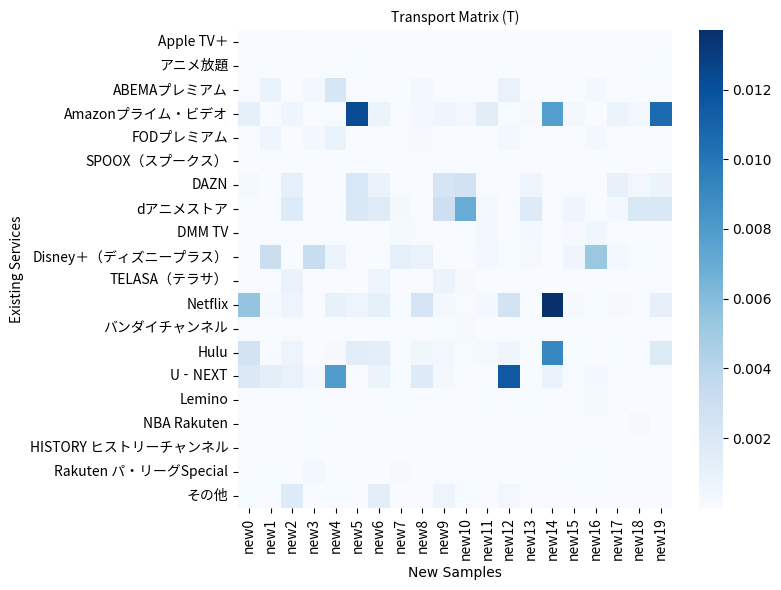

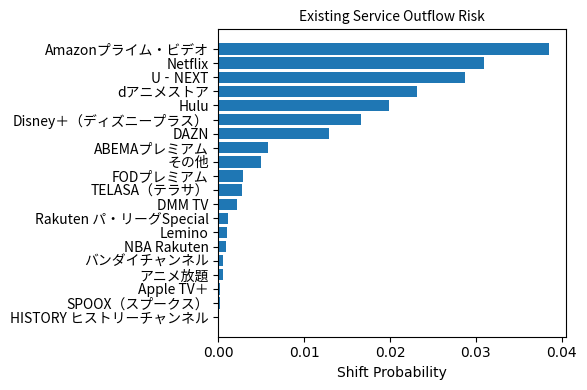

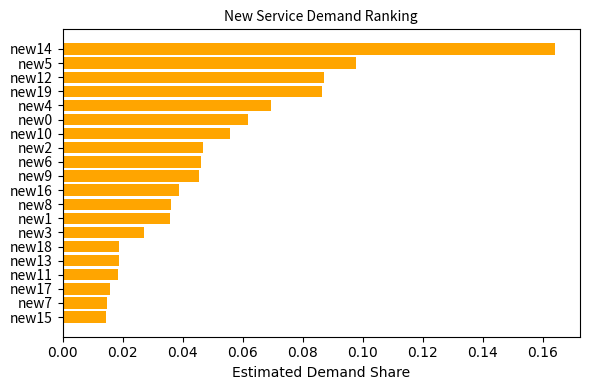

In [25]:
# ─────────────────────────────────────────────────────────────────
# 6. 可視化
# ─────────────────────────────────────────────────────────────────

# （a）T 行列ヒートマップ
if args.plot_heatmap:
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(T, cmap="Blues",
                     yticklabels=service_names,
                     xticklabels=[f"new{i}" for i in range(m)])

    # ★ フォントを日本語対応に上書き
    ax.set_yticklabels(service_names, fontproperties=font_prop)
    ax.set_xticklabels([f"new{i}" for i in range(m)],
                       rotation=90, fontproperties=font_prop)  # ←不要なら削除

    plt.title("Transport Matrix (T)", fontproperties=font_prop)
    plt.xlabel("New Samples")
    plt.ylabel("Existing Services", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

# （b）既存サービスの流出リスクバー
if args.plot_shift:
    order = np.argsort(shift_prob)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(range(n), shift_prob[order])
    plt.yticks(range(n), [service_names[i] for i in order], fontproperties=font_prop)
    plt.gca().invert_yaxis()
    plt.xlabel("Shift Probability")
    plt.title("Existing Service Outflow Risk", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

# （c）新サービスの流入ランキング
if args.plot_inbound:
    # （c）新サービスの推定需要シェア
    order = np.argsort(inbound_share)[::-1]                # ★ シェアで並べ替え
    plt.figure(figsize=(6,4))
    plt.barh(range(m), inbound_share[order], color="orange")  # ★ シェアを描画
    plt.yticks(range(m), [f"new{i}" for i in order], fontproperties=font_prop)
    plt.gca().invert_yaxis()
    plt.xlabel("Estimated Demand Share")
    plt.title("New Service Demand Ranking", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

In [26]:
print("mass_curr:", mass_curr)
print("sum:", mass_curr.sum())


mass_curr: [0.00149076 0.00178891 0.02116875 0.22778772 0.01192606 0.00089445
 0.07781753 0.08706023 0.01341682 0.06112105 0.01282051 0.19022063
 0.00178891 0.12462731 0.12373286 0.00626118 0.00566488 0.00029815
 0.00685748 0.02325581]
sum: 1.0


In [27]:
print("D の統計量:", D.min(), D.max(), D.mean())


D の統計量: 0.11293505 1.7803311 0.97838455


In [28]:
print("T min / max:", T.min(), T.max(), "   total mass:", T.sum())


T min / max: 4.973915614712241e-08 0.013705242284549498    total mass: 0.19363790072769504


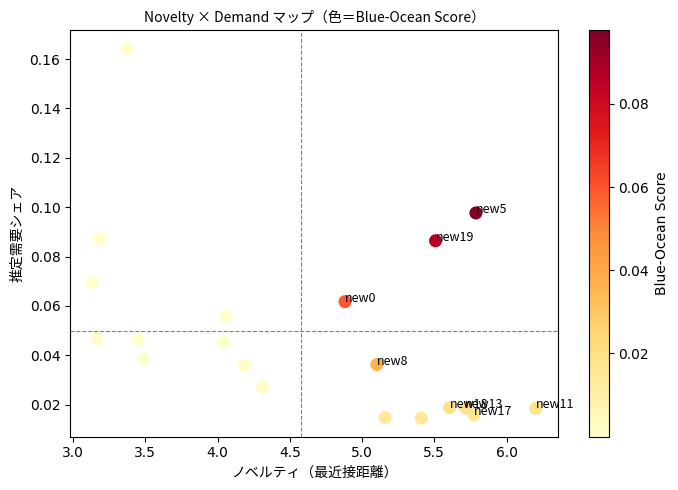

=== Blue-Ocean Score TOP10 ===


,service,Novelty,Demand,BlueScore
5,new5,5.787338,0.097659,0.097658
19,new19,5.508362,0.086409,0.086402
0,new0,4.881760,0.061738,0.058953
8,new8,5.101926,0.036254,0.036065
18,new18,5.604457,0.018814,0.018813
13,new13,5.714252,0.018732,0.018732
11,new11,6.202129,0.018546,0.018546
17,new17,5.772130,0.015895,0.015895
7,new7,5.159192,0.014838,0.014795
15,new15,5.409215,0.014514,0.014511


In [29]:
# =============================================================
# 7. ブルーオーシャン可視化  ★ ここから下を末尾に追記するだけで OK
# =============================================================
from sklearn.metrics import pairwise_distances

# -------------------------------------------------------------
# ① ノベルティ (Novelty) を計算
#     ＝ 新サービスと既存サービスの最近接距離
# -------------------------------------------------------------
dist_to_existing = pairwise_distances(Y_fut, X_curr)    # (m × n)
novelty = dist_to_existing.min(axis=1)                  # (m,)

# -------------------------------------------------------------
# ② 需要 (Demand) = inbound_share （前ステップで作成済み）
# -------------------------------------------------------------
demand = inbound_share                                  # (m,)

# -------------------------------------------------------------
# ③ Blue-Ocean Score（シグモイド重み付き）
#     γ は「どれぐらい Novelty を強調するか」の温度パラメータ
# -------------------------------------------------------------
gamma = 10                                   # ★ 調整してみてください
mu    = novelty.mean()
blue_score = demand / (1 + np.exp(-gamma * (novelty - mu)))

# -------------------------------------------------------------
# ④ DataFrame にまとめる
# -------------------------------------------------------------
df_bo = pd.DataFrame({
    "service"   : [f"new{i}" for i in range(m)],
    "Novelty"   : novelty,
    "Demand"    : demand,
    "BlueScore" : blue_score
}).sort_values("BlueScore", ascending=False)

# -------------------------------------------------------------
# ⑤ 散布図 (Novelty × Demand) — 点色を BlueScore で着色
# -------------------------------------------------------------
plt.figure(figsize=(7,5))
sc = plt.scatter(df_bo["Novelty"], df_bo["Demand"],
                 c=df_bo["BlueScore"], cmap="YlOrRd", s=70)
plt.colorbar(sc, label="Blue-Ocean Score")

#  ラベルを付ける（スコア上位 N 件だけ表示すると見やすい）
N_LABEL = 8
for _, row in df_bo.head(N_LABEL).iterrows():
    plt.text(row.Novelty, row.Demand, row.service, fontsize=9,
             fontproperties=font_prop)

#  平均ライン
plt.axhline(df_bo["Demand"].mean(), color="grey", ls="--", lw=.8)
plt.axvline(df_bo["Novelty"].mean(), color="grey", ls="--", lw=.8)

plt.xlabel("ノベルティ（最近接距離）", fontproperties=font_prop)
plt.ylabel("推定需要シェア", fontproperties=font_prop)
plt.title("Novelty × Demand マップ（色＝Blue-Ocean Score）",
          fontproperties=font_prop)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# ⑥ ランキング表（上位 10 件）をコンソール出力
# -------------------------------------------------------------
print("=== Blue-Ocean Score TOP10 ===")
display(df_bo.head(10))
